# Acid_time_split

```
RM01/0006     503
RM01/0007     573
RM01/0004     672
RM01/0001    1507

Earliest data of Amonia: 2014-12-01
```

## Table of contents
0. Data preparations
* Import data
* Impute data
* Slice data for naive forecast
* Feature engineering
* Split data into train and test sets
* Create X, y
* Log transformation
* Standardlisation
* Drop external price drivers to create X_train_ar and X_test_ar
1. 1-month predictions
* Naive forecast with test_df and visualisation
* Lasso with only autoregressions, visualise testing set
* Lasso with autoregressions and external price drivers, visualise testing set

2. 3-month predictions
* Slice data for 3-month lag
* Naive forecast with test_df and visualisation
* Lasso with only autoregressions, visualise testing set
* Lasso with autoregressions and external price drivers, visualise testing set

3. 6-month predictions
* Slice data for 6-month lag
* Naive forecast with test_df and visualisation
* Lasso with only autoregressions, visualise testing set
* Lasso with autoregressions and external price drivers, visualise testing set

In [1]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable


# 0. Data preparation

In [2]:
import preprocessor as pre
import naiveforecastor as nf
import visualiser as visual
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
from matplotlib import pyplot as plt

# Import data
gas_df = pre.get_Fred_data('PNGASEUUSDM',2014,2024)
wheat_df = pre.get_Fred_data('PWHEAMTUSDM',2014,2024)
ammonia_df = pre.get_Fred_data('WPU0652013A',2014,2024)
elec_df = pre.clean_elec_csv('Data_flat_files/ELECTRICITY_03_2024.csv',2014,2024)

df = pre.clean_pred_price_evo_csv("Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv",2014,2023)

target = 'acid'.lower()

RM_codes = ['RM01/0001','RM01/0004','RM01/0006','RM01/0007']

external_drivers = {
    "PNGASEUUSDM": gas_df,
    "PWHEAMTUSDM": wheat_df,
    "WPU0652013A": ammonia_df,
    "Electricity": elec_df
}

slicing_columns = ["PNGASEUUSDM","PWHEAMTUSDM","WPU0652013A","Electricity","AR"]

In [3]:
# Impute raw data of target variables 
imputed_df, missing = pre.impute_pred_price_evo_csv(df)

# Slice data for naive forecast
naive_df = imputed_df[imputed_df.Year == 2023]

# Feature engineering
dummy_df = pre.get_dummies_and_average_price(imputed_df,target,*RM_codes)
feature_df = pre.generate_features(1,12,dummy_df,*RM_codes, **external_drivers)

# Split data into train and test sets
train_df = feature_df[feature_df.Year.between(2016,2022)]
test_df = feature_df[feature_df.Year == 2023]

# Create X, y
X_train = train_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X_test = test_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)

y_train = train_df['Average_price'].values
y_test = test_df['Average_price'].values

# # Log transformation and standardlisation
# y_train_log = np.log(y_train)
# y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
# y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
# y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

In [4]:
# Drop external price drivers to create X_train_ar and X_test_ar
X_train_ar = X_train.copy()
X_test_ar = X_test.copy()

try:
    for driver in external_drivers.keys():
        X_train_ar = X_train_ar.drop([f"{driver}_{i}" for i in range(1,13)], axis=1, errors="ignore")
        X_test_ar = X_test_ar.drop([f"{driver}_{i}" for i in range(1,13)], axis=1, errors="ignore")
    
    assert not any(col.startswith(tuple(key for key in external_drivers.keys())) for col in X_train_ar.columns), "df not sliced correctly"
    assert not any(col.startswith(tuple(key for key in external_drivers.keys())) for col in X_test_ar.columns), "df not sliced correctly"
    print(X_train_ar.columns)
    print(X_test_ar.columns)
    
except AssertionError:
    print("Unable to slice DataFrame")
    
scaler_ar = StandardScaler()
X_train_ar_scaled = scaler_ar.fit_transform(X_train_ar)
X_test_ar_scaled = scaler_ar.transform(X_test_ar)

Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'AR_1', 'AR_2', 'AR_3', 'AR_4',
       'AR_5', 'AR_6', 'AR_7', 'AR_8', 'AR_9', 'AR_10', 'AR_11', 'AR_12'],
      dtype='object')
Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'AR_1', 'AR_2', 'AR_3', 'AR_4',
       'AR_5', 'AR_6', 'AR_7', 'AR_8', 'AR_9', 'AR_10', 'AR_11', 'AR_12'],
      dtype='object')


# 1-month predictions

## Naive forecast with test_df and visualisation

MAPE of 1 month(s) acid Naive Forecast: 0.080
MSE of 1 month(s) acid Naive Forecast: 0.030


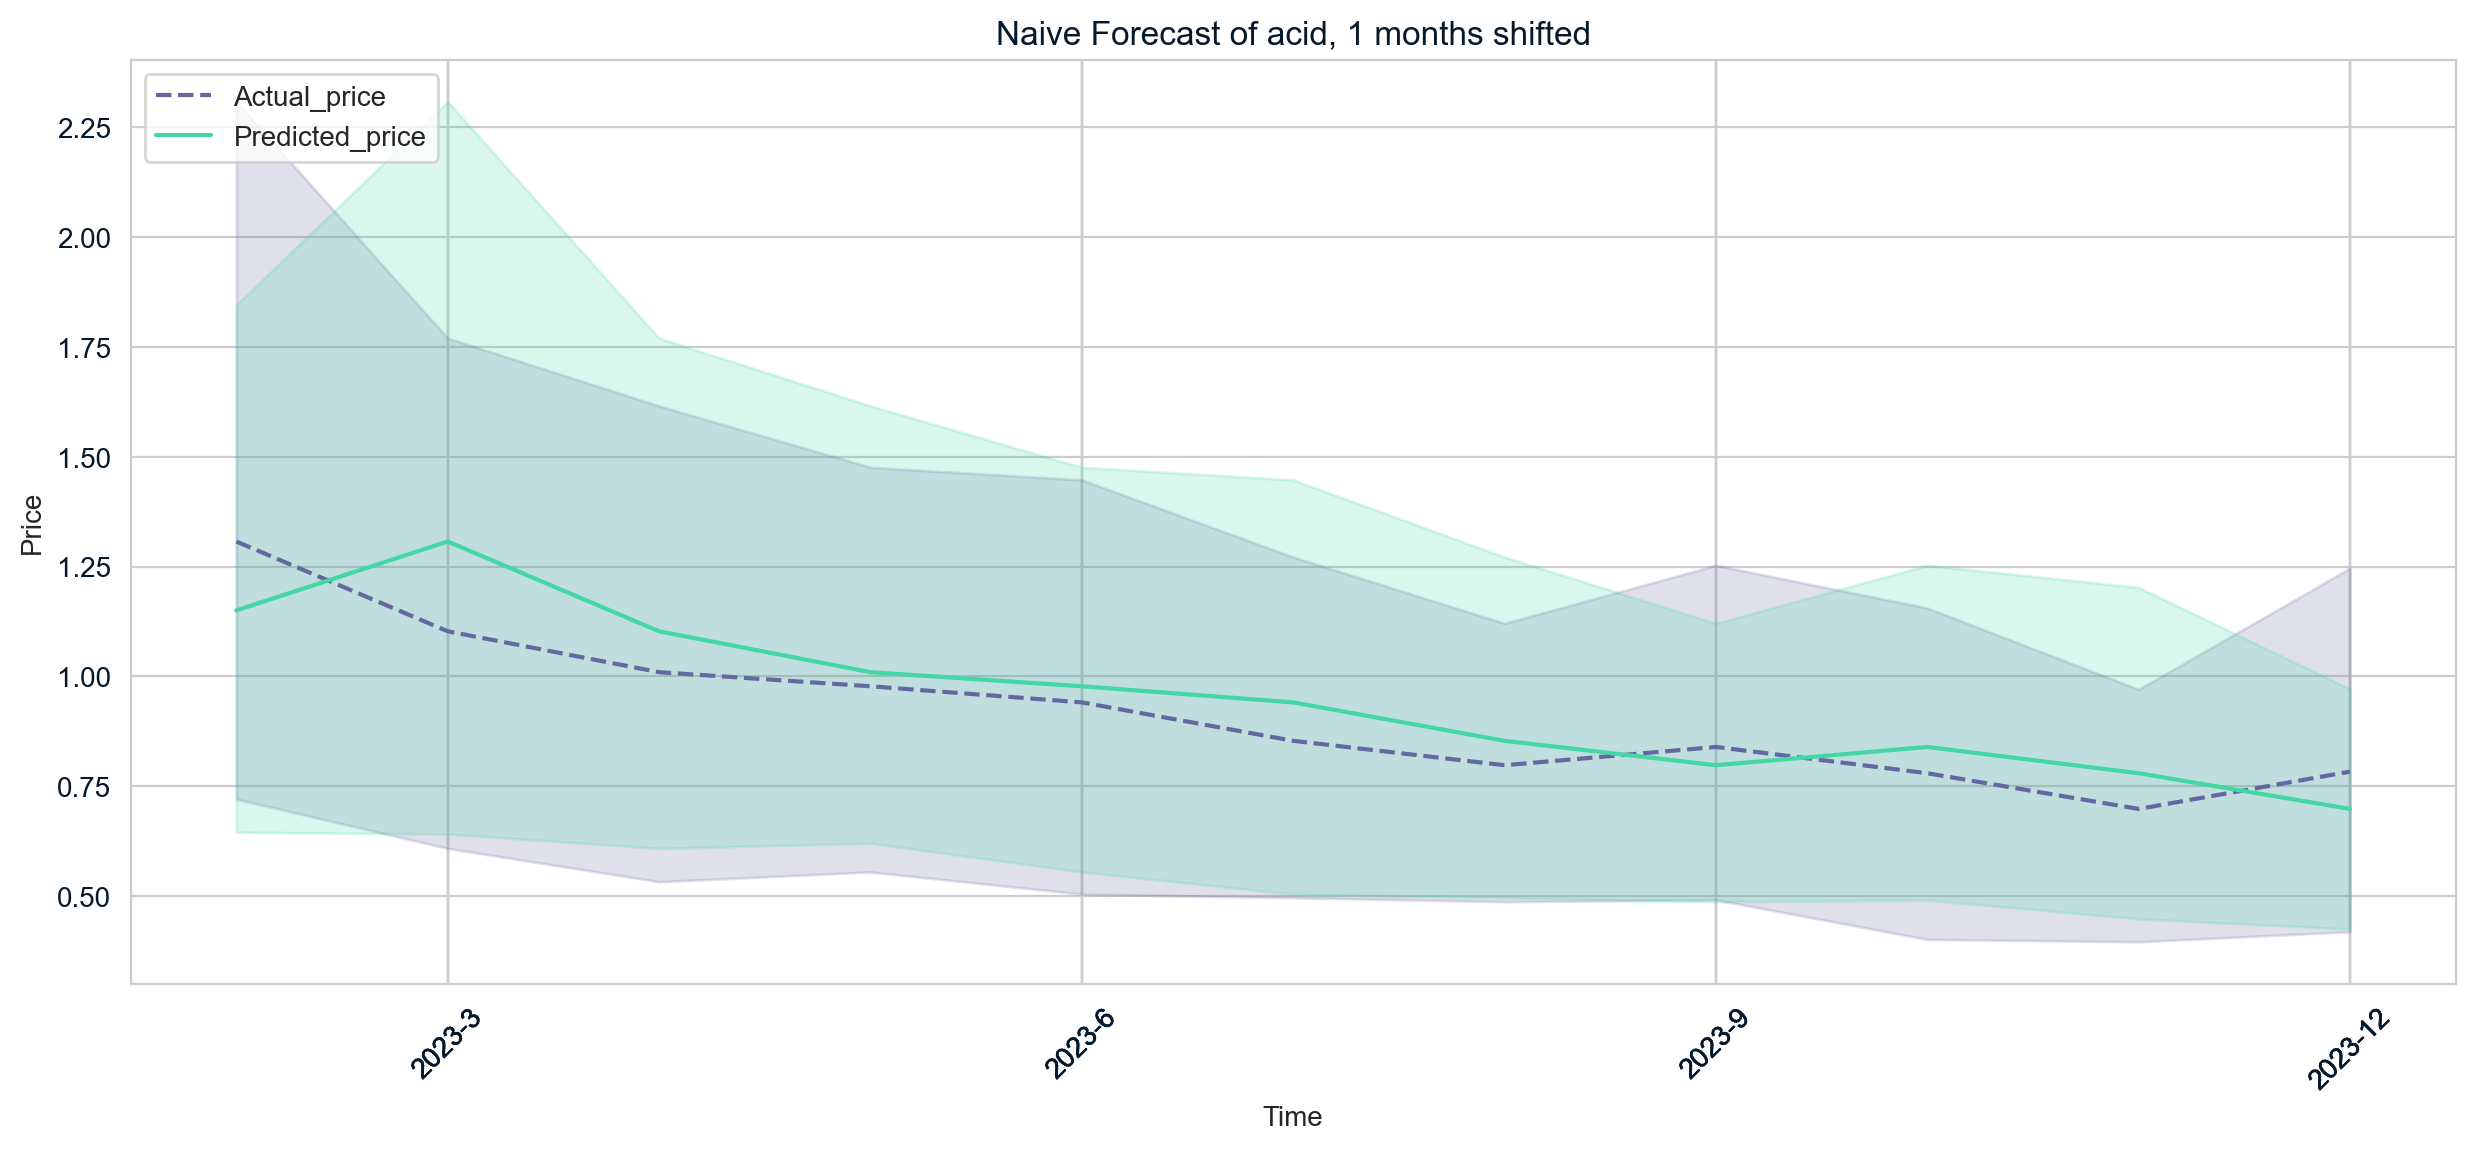

In [5]:
nf.naive_forest(naive_df,target,1,missing)

## Lasso with only autoregressions, visualise testing set

In [6]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_ar_scaled, y_train_scaled)

# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(X_train_ar.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_ar_scaled)
# y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_train_inverse = scaler_y.inverse_transform(y_pred_train.reshape(-1,1))

print("MAPE, 1-month, AR only, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 0.04801610053351117
Best R-squared score: 0.883
Coefficients of the selected features in the best Lasso model:
RM01/0004: -0.0
RM01/0006: 0.0
RM01/0007: -0.0
AR_1: 0.625
AR_2: 0.294
AR_3: 0.0
AR_4: 0.005
AR_5: 0.0
AR_6: 0.0
AR_7: 0.0
AR_8: 0.0
AR_9: 0.0
AR_10: 0.0
AR_11: 0.0
AR_12: 0.0
MAPE, 1-month, AR only, train:  0.092


In [7]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_ar_scaled)
# y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test.reshape(-1,1))

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_ar_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 1-month, AR only, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.04801610053351117)
Test Set R-squared score: 0.905
MAPE, 1-month, AR only, test:  0.115


## Lasso with autoregressions and external price drivers, visualise testing set

In [8]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(X_train.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(X_train.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
# y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_train_inverse = scaler_y.inverse_transform(y_pred_train.reshape(-1,1))

print("MAPE, 1-month, all features, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 0.05401810060020007
Best R-squared score: 0.879
Coefficients of the selected features in the best Lasso model:
RM01/0004: -0.0
RM01/0006: 0.0
RM01/0007: -0.0
PNGASEUUSDM_1: 0.0
PWHEAMTUSDM_1: 0.0
WPU0652013A_1: 0.02
Electricity_1: 0.0
PNGASEUUSDM_2: 0.0
PWHEAMTUSDM_2: 0.0
WPU0652013A_2: 0.0
Electricity_2: 0.0
PNGASEUUSDM_3: 0.0
PWHEAMTUSDM_3: 0.0
WPU0652013A_3: 0.0
Electricity_3: 0.0
PNGASEUUSDM_4: 0.0
PWHEAMTUSDM_4: 0.0
WPU0652013A_4: 0.0
Electricity_4: 0.0
PNGASEUUSDM_5: 0.0
PWHEAMTUSDM_5: 0.0
WPU0652013A_5: 0.0
Electricity_5: 0.0
PNGASEUUSDM_6: 0.0
PWHEAMTUSDM_6: 0.0
WPU0652013A_6: 0.0
Electricity_6: 0.0
PNGASEUUSDM_7: 0.0
PWHEAMTUSDM_7: 0.0
WPU0652013A_7: 0.0
Electricity_7: -0.0
PNGASEUUSDM_8: 0.0
PWHEAMTUSDM_8: 0.0
WPU0652013A_8: 0.0
Electricity_8: -0.0
PNGASEUUSDM_9: 0.0
PWHEAMTUSDM_9: 0.0
WPU0652013A_9: 0.0
Electricity_9: -0.0
PNGASEUUSDM_10: -0.0
PWHEAMTUSDM_10: 0.0
WPU0652013A_10: -0.0
Electricity_10: -0.0
PNGASEUUSDM_11: -0.0
PWHEAMTUSDM_11: 0.0
WPU06520

In [9]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
# y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test.reshape(-1,1))

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 1-month, all features, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.05401810060020007)
Test Set R-squared score: 0.906
MAPE, 1-month, all features, test:  0.121


# 3-month predictions

MAPE of 3 month(s) acid Naive Forecast: 0.159
MSE of 3 month(s) acid Naive Forecast: 0.060


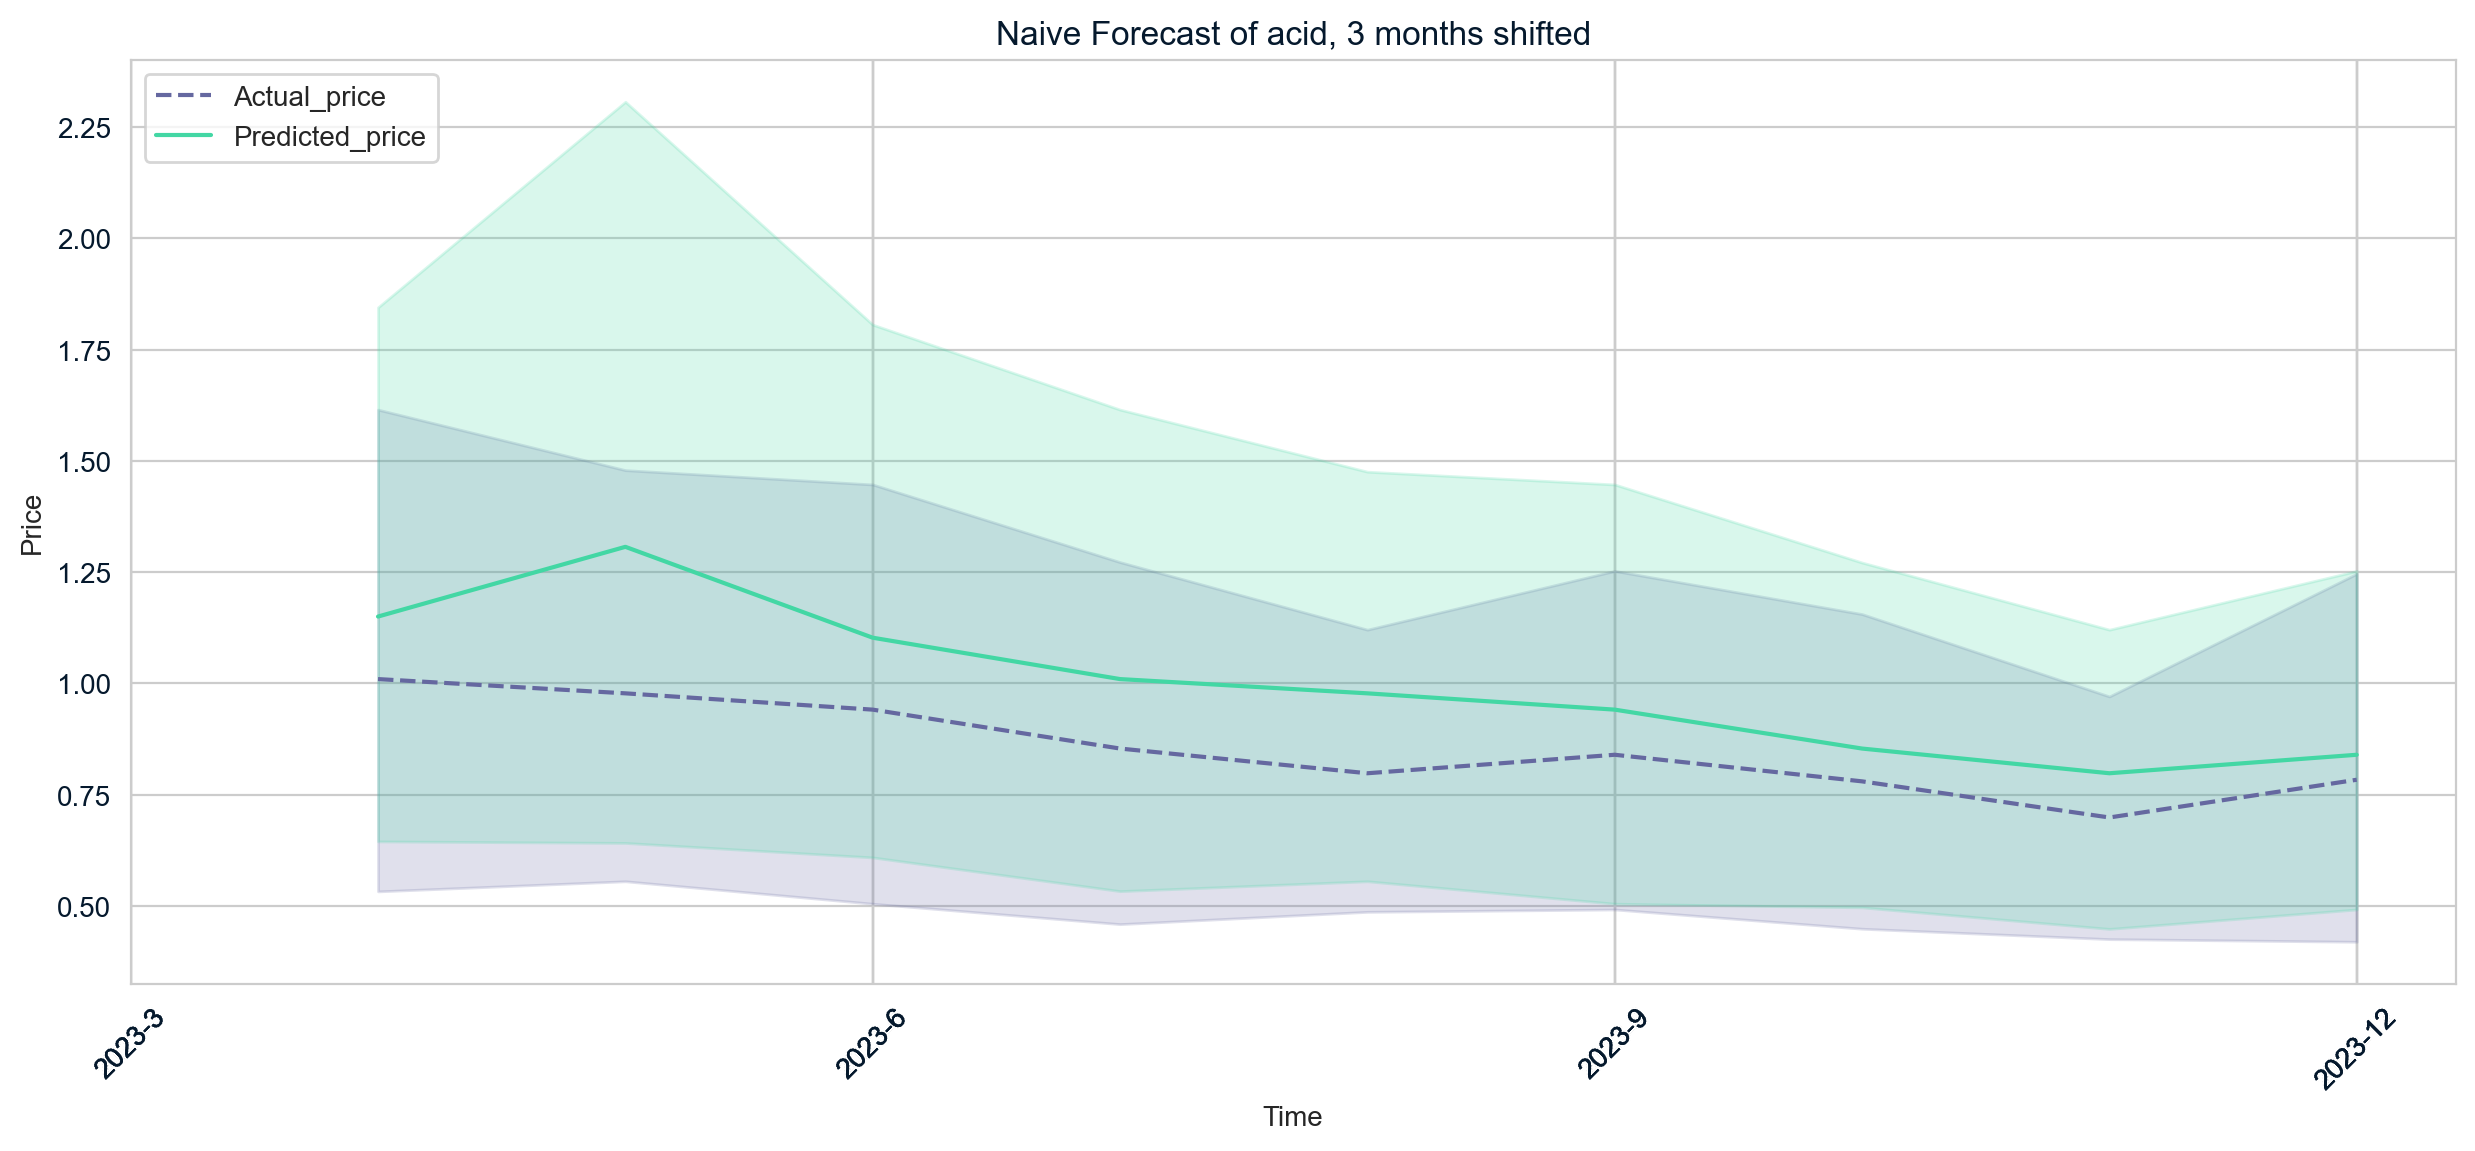

In [10]:
nf.naive_forest(naive_df,target,3,missing)

## Lasso with only autoregressions visualise testing set

In [11]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Slice data for 3-month lag
try:
    X_train_ar=X_train_ar.drop([f"AR_{i}" for i in range(1,3)], axis=1, errors='ignore')
    assert not any(col.endswith(("_1", "_2" )) for col in X_train_ar.columns) , "df not sliced correctly"
    X_test_ar=X_test_ar.drop([f"AR_{i}" for i in range(1,3)], axis=1, errors='ignore')
    assert not any(col.endswith(("_1", "_2" )) for col in X_test_ar.columns) , "df not sliced correctly"
    print(X_train_ar.columns)
    print(X_test_ar.columns)
except AssertionError:
    print("Unable to slice DataFrame")


scaler_ar_3 = StandardScaler()
X_train_ar_scaled = scaler_ar_3.fit_transform(X_train_ar)
X_test_ar_scaled = scaler_ar_3.transform(X_test_ar)

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_ar_scaled, y_train_scaled)

# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(X_train_ar.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_ar_scaled)
# y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_train_inverse = scaler_y.inverse_transform(y_pred_train.reshape(-1,1))

print("MAPE, 3-month, AR only, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))

Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'AR_3', 'AR_4', 'AR_5', 'AR_6',
       'AR_7', 'AR_8', 'AR_9', 'AR_10', 'AR_11', 'AR_12'],
      dtype='object')
Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'AR_3', 'AR_4', 'AR_5', 'AR_6',
       'AR_7', 'AR_8', 'AR_9', 'AR_10', 'AR_11', 'AR_12'],
      dtype='object')
Best alpha parameter: 0.11037021233744582
Best R-squared score: 0.637
Coefficients of the selected features in the best Lasso model:
RM01/0004: -0.0
RM01/0006: 0.0
RM01/0007: -0.0
AR_3: 0.588
AR_4: 0.233
AR_5: 0.0
AR_6: 0.0
AR_7: 0.0
AR_8: 0.0
AR_9: 0.0
AR_10: 0.0
AR_11: 0.0
AR_12: 0.0
MAPE, 3-month, AR only, train:  0.164


In [12]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_ar_scaled)
# y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test.reshape(-1,1))

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_ar_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 3-month, AR only, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.11037021233744582)
Test Set R-squared score: 0.797
MAPE, 3-month, AR only, test:  0.23


## Lasso with autoregressions and external price drivers, visualise testing set

In [13]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Slice data for 3-month lag
try:
    for feature in slicing_columns:
        X_train=X_train.drop([f"{feature}_{i}" for i in range(1,3)], axis=1, errors='ignore')
        X_test=X_test.drop([f"{feature}_{i}" for i in range(1,3)], axis=1, errors='ignore')
    assert not any(col.endswith(("_1", "_2" )) for col in X_train.columns) , "df not sliced correctly"
    assert not any(col.endswith(("_1", "_2" )) for col in X_test.columns) , "df not sliced correctly"
    print(X_train.columns)
    print(X_test.columns)
except AssertionError:
    print("Unable to slice DataFrame")

scaler_3 = StandardScaler()
X_train_scaled = scaler_3.fit_transform(X_train)
X_test_scaled = scaler_3.transform(X_test)

## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(X_train.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(X_train.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
# y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_train_inverse = scaler_y.inverse_transform(y_pred_train.reshape(-1,1))

print("MAPE, 3-month, all features, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))

Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'PNGASEUUSDM_3', 'PWHEAMTUSDM_3',
       'WPU0652013A_3', 'Electricity_3', 'PNGASEUUSDM_4', 'PWHEAMTUSDM_4',
       'WPU0652013A_4', 'Electricity_4', 'PNGASEUUSDM_5', 'PWHEAMTUSDM_5',
       'WPU0652013A_5', 'Electricity_5', 'PNGASEUUSDM_6', 'PWHEAMTUSDM_6',
       'WPU0652013A_6', 'Electricity_6', 'PNGASEUUSDM_7', 'PWHEAMTUSDM_7',
       'WPU0652013A_7', 'Electricity_7', 'PNGASEUUSDM_8', 'PWHEAMTUSDM_8',
       'WPU0652013A_8', 'Electricity_8', 'PNGASEUUSDM_9', 'PWHEAMTUSDM_9',
       'WPU0652013A_9', 'Electricity_9', 'PNGASEUUSDM_10', 'PWHEAMTUSDM_10',
       'WPU0652013A_10', 'Electricity_10', 'PNGASEUUSDM_11', 'PWHEAMTUSDM_11',
       'WPU0652013A_11', 'Electricity_11', 'PNGASEUUSDM_12', 'PWHEAMTUSDM_12',
       'WPU0652013A_12', 'Electricity_12', 'AR_3', 'AR_4', 'AR_5', 'AR_6',
       'AR_7', 'AR_8', 'AR_9', 'AR_10', 'AR_11', 'AR_12'],
      dtype='object')
Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'PNGASEUUSDM_3', 'PWHEAMTUSDM_3',

In [14]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
# y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test.reshape(-1,1))

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 3-month, all features, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.10736921230410137)
Test Set R-squared score: 0.777
MAPE, 3-month, all features, test:  0.264


# 6-month predictions

## Naive forecast with test_df and visualisation

MAPE of 6 month(s) acid Naive Forecast: 0.339
MSE of 6 month(s) acid Naive Forecast: 0.186


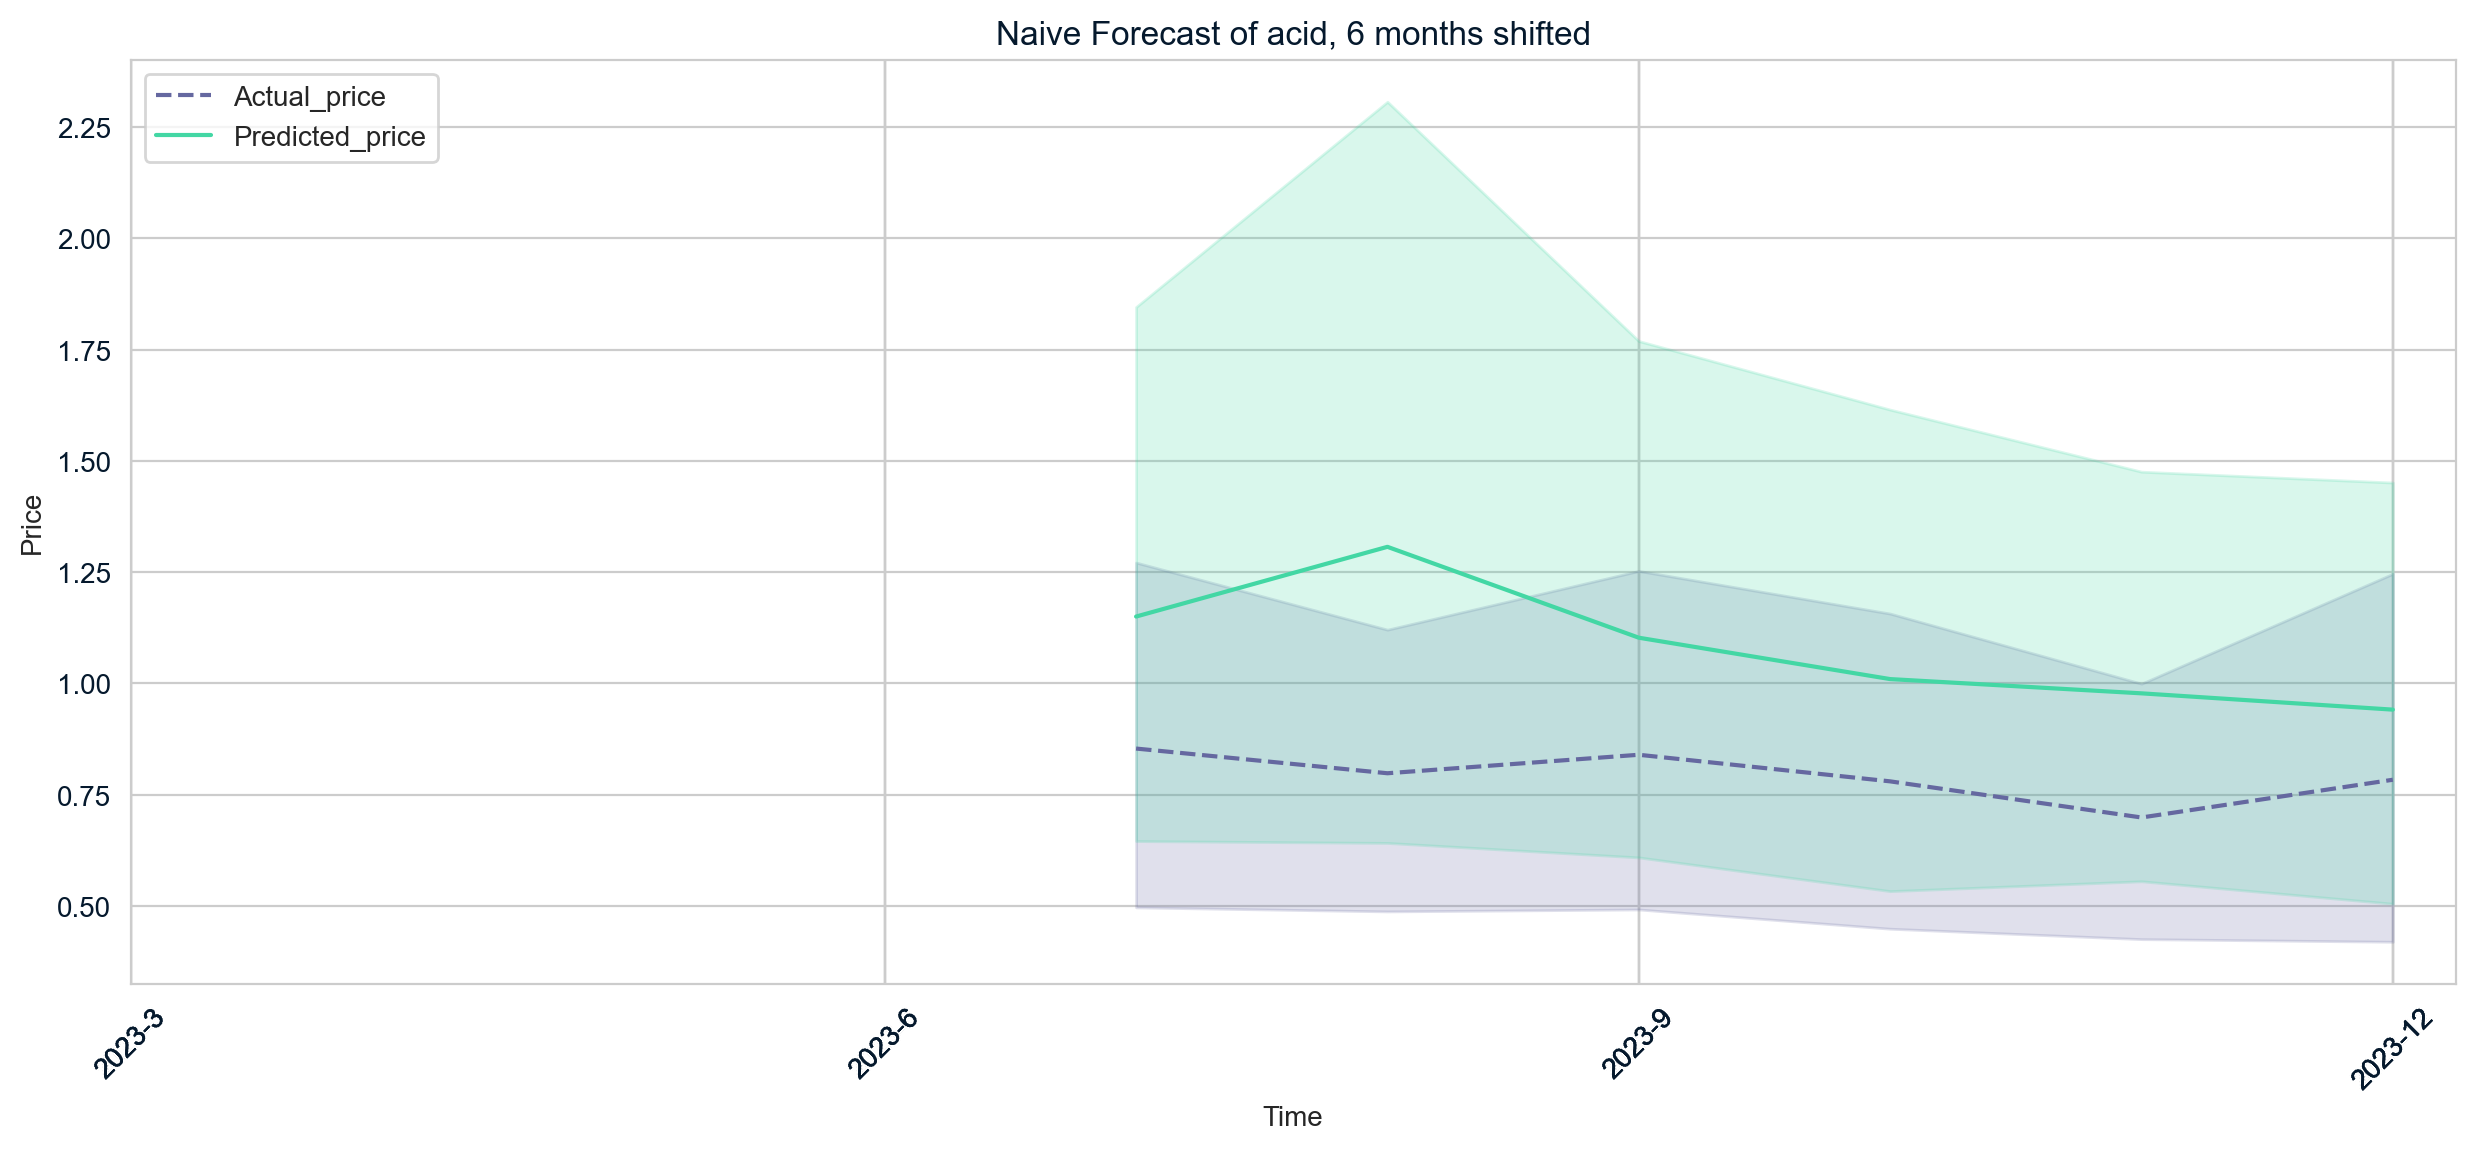

In [15]:
nf.naive_forest(naive_df,target,6,missing)

## Lasso with only autoregressions, visualise testing set

In [16]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Slice data for 6-month lag
try:
    X_train_ar=X_train_ar.drop([f"AR_{i}" for i in range(1,6)], axis=1, errors='ignore')
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5")) for col in X_train_ar.columns) , "df not sliced correctly"
    X_test_ar=X_test_ar.drop([f"AR_{i}" for i in range(1,6)], axis=1, errors='ignore')
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5")) for col in X_test_ar.columns) , "df not sliced correctly"
    print(X_train_ar.columns)
    print(X_test_ar.columns)
except AssertionError:
    print("Unable to slice DataFrame")


scaler_ar_6 = StandardScaler()
X_train_ar_scaled = scaler_ar_6.fit_transform(X_train_ar)
X_test_ar_scaled = scaler_ar_6.transform(X_test_ar)

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_ar_scaled, y_train_scaled)

# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(X_train_ar.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_ar_scaled)
# y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_train_inverse = scaler_y.inverse_transform(y_pred_train.reshape(-1,1))

print("MAPE, 6-month, AR only, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))

Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'AR_6', 'AR_7', 'AR_8', 'AR_9',
       'AR_10', 'AR_11', 'AR_12'],
      dtype='object')
Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'AR_6', 'AR_7', 'AR_8', 'AR_9',
       'AR_10', 'AR_11', 'AR_12'],
      dtype='object')
Best alpha parameter: 0.21473832460820275
Best R-squared score: 0.04
Coefficients of the selected features in the best Lasso model:
RM01/0004: -0.0
RM01/0006: 0.0
RM01/0007: -0.0
AR_6: 0.588
AR_7: 0.034
AR_8: 0.0
AR_9: 0.0
AR_10: 0.0
AR_11: 0.0
AR_12: 0.0
MAPE, 6-month, AR only, train:  0.282


In [17]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_ar_scaled)
# y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test.reshape(-1,1))

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_ar_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 6-month, AR only, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.21473832460820275)
Test Set R-squared score: 0.551
MAPE, 6-month, AR only, test:  0.379


## Lasso with autoregressions and external price drivers, visualise testing set

In [20]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Slice data for 6-month lag
try:
    for feature in slicing_columns:
        X_train=X_train.drop([f"{feature}_{i}" for i in range(1,6)], axis=1, errors='ignore')
        X_test=X_test.drop([f"{feature}_{i}" for i in range(1,6)], axis=1, errors='ignore')
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5")) for col in X_train.columns) , "df not sliced correctly"
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5")) for col in X_test.columns) , "df not sliced correctly"
    print(X_train.columns)
    print(X_test.columns)
except AssertionError:
    print("Unable to slice DataFrame")

scaler_6 = StandardScaler()
X_train_scaled = scaler_6.fit_transform(X_train)
X_test_scaled = scaler_6.transform(X_test)

## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(X_train.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(X_train.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
# y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_train_inverse = scaler_y.inverse_transform(y_pred_train.reshape(-1,1)).reshape(-1)

print("MAPE, 6-month, all features, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))

Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'PNGASEUUSDM_6', 'PWHEAMTUSDM_6',
       'WPU0652013A_6', 'Electricity_6', 'PNGASEUUSDM_7', 'PWHEAMTUSDM_7',
       'WPU0652013A_7', 'Electricity_7', 'PNGASEUUSDM_8', 'PWHEAMTUSDM_8',
       'WPU0652013A_8', 'Electricity_8', 'PNGASEUUSDM_9', 'PWHEAMTUSDM_9',
       'WPU0652013A_9', 'Electricity_9', 'PNGASEUUSDM_10', 'PWHEAMTUSDM_10',
       'WPU0652013A_10', 'Electricity_10', 'PNGASEUUSDM_11', 'PWHEAMTUSDM_11',
       'WPU0652013A_11', 'Electricity_11', 'PNGASEUUSDM_12', 'PWHEAMTUSDM_12',
       'WPU0652013A_12', 'Electricity_12', 'AR_6', 'AR_7', 'AR_8', 'AR_9',
       'AR_10', 'AR_11', 'AR_12'],
      dtype='object')
Index(['RM01/0004', 'RM01/0006', 'RM01/0007', 'PNGASEUUSDM_6', 'PWHEAMTUSDM_6',
       'WPU0652013A_6', 'Electricity_6', 'PNGASEUUSDM_7', 'PWHEAMTUSDM_7',
       'WPU0652013A_7', 'Electricity_7', 'PNGASEUUSDM_8', 'PWHEAMTUSDM_8',
       'WPU0652013A_8', 'Electricity_8', 'PNGASEUUSDM_9', 'PWHEAMTUSDM_9',
       'WPU0652013A_9',

In [21]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
# y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test.reshape(-1,1)).reshape(-1)

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 6-month, all features, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.23174399146382127)
Test Set R-squared score: 0.54
MAPE, 6-month, all features, test:  0.422
